# Init

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
kb = 3.1668105e-06 # in hartree
ha2ev = 27.211386
kbev = kb*ha2ev # in eV
T0=90
natomfcc=1440
natomsf=1320
nfreefcc=(natomfcc-1)*3
nfreesf=(natomsf-1)*3

## The energy units in this notebook is in eV, unless specified otherwise

# 0K results

In [3]:
U0fcc=-6137.04868222  # in eV
U0sf=-5625.6279587

# The free energy of the reference harmonic system with fixed mass at 90K
### $A_\text{h}(T_0)=k_B T_0\sum_{i=1}^{3N-3}\ln(\dfrac{\hbar \omega_i}{k_B T_0})$

In [4]:
T0=90
eva = np.loadtxt("ipi-90K/phonon-0K/fcc-0K.eigval")
# The square root of the eigenvalues of the phonon modes is the frequency in the unit of hartree
AharmfccT0 = ha2ev*T0*kb*np.log(np.sqrt(eva[3:])/(T0*kb)).sum()
print AharmfccT0

36.7716353617


In [5]:
eva = np.loadtxt("ipi-90K/phonon-0K/sf-0K.eigval")
# The square root of the eigenvalues of the phonon modes is the frequency in the unit of hartree
AharmsfT0 = ha2ev*T0*kb*np.log(np.sqrt(eva[3:])/(T0*kb)).sum()
print AharmsfT0

33.7150138247


In [6]:
(AharmsfT0-AharmfccT0*11/12)*10

0.076814098131308128

# Anharmonic correction of A at 90K
### $A(V,T_0)-A_\text{h}(V,T_0)=\int_0^1 d \lambda \left<U-U_\text{h}\right>_{V,T_0,\lambda}$

In [7]:
dhdlfcc = np.loadtxt("ipi-90K/lambda-ti/dhdl.fcc")
it=0.0
iterror=0.0
for i in xrange(len(dhdlfcc)-1):
    #print dhdlfcc[i,0],dhdlfcc[i,1]
    it += 0.5*(dhdlfcc[i,1]+dhdlfcc[i+1,1])*(dhdlfcc[i+1,0]-dhdlfcc[i,0])
    iterror += 0.5*(dhdlfcc[i,2]**2.+dhdlfcc[i,2]**2.)*(dhdlfcc[i+1,0]-dhdlfcc[i,0])
#print it, iterror
AanhfccT0=it
AanhfccT0error=iterror
AfccT0=AharmfccT0+AanhfccT0
print AharmfccT0, U0fcc, AanhfccT0
print AfccT0, "+/-", AanhfccT0error

36.7716353617 -6137.04868222 -6137.14757
-6100.37593464 +/- 1.11485541137e-07


In [8]:
dhdlsf = np.loadtxt("ipi-90K/lambda-ti/dhdl.sf")
it=0.0
iterror=0.0
for i in xrange(len(dhdlsf)-1):
    it += 0.5*(dhdlsf[i,1]+dhdlsf[i+1,1])*(dhdlsf[i+1,0]-dhdlsf[i,0])
    iterror += 0.5*(dhdlsf[i,2]**2.+dhdlsf[i,2]**2.)*(dhdlsf[i+1,0]-dhdlsf[i,0])
#print it, iterror
AanhsfT0=it
AanhsfT0error=iterror
AsfT0=AharmsfT0+AanhsfT0
print AharmsfT0, U0sf, AanhsfT0
print AsfT0, "+/-", AanhsfT0error

33.7150138247 -5625.6279587 -5625.718305
-5592.00329118 +/- 5.89338450374e-08


# Transform the Helmholtz free energy to the Gibbs free energy
#### We used the isothermal-isobaric ensemble (NPT) in the simulations with zero external pressure, and allowed the 3 dimensions of the orthorhombic simulation cell are allowed to fluctuate independently. In this case we have
#### $G(P,T) = A (\textbf{h},T) + P \text{det}(\textbf{h}) + k_B T \ln \rho(\textbf{h}|P,T)$.
#### As $P=0$ in our case, so here we only need to compute $k_B T \ln \rho(\textbf{h}|P,T)$
#### For convinience, we used a bash script (processrhoxyz.sh) to compute this quantity.

In [10]:
A2GfccT0=[0.095307, 0.000656901]
A2GsfT0=[0.0936117, 0.000727072]

GfccT0=AfccT0+A2GfccT0[0]
GfccT0error=AanhfccT0error+A2GfccT0[1]
print "Gfcc90K:",GfccT0, "+/-", GfccT0error

GsfT0=AsfT0+A2GsfT0[0]
GsfT0error=AanhsfT0error+A2GsfT0[1]
print "Gsf 90K:",GsfT0, "+/-", GsfT0error


Gfcc90K: -6100.28062764 +/- 0.000657012485541
Gsf 90K: -5591.90967948 +/- 0.000727130933845


# Thermodynamic Intergation at NPT
## $-T_1\int_{T_0}^{T_1} \dfrac{\left<\delta H\right>_{P,T}}{ T^2} dT=-T_1\int_{\ln T_0}^{\ln T_1} \left<\delta H\right>_{P,T}e^{-y} dy$,

## In our case P=0 so $H=U$

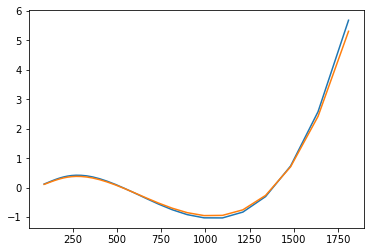

In [12]:
dhnptlist = np.sort(np.loadtxt("lammps-npt/PE.list"), axis=0)
#print dhnptlist
ttnpt = dhnptlist[:,0]
ltnpt = np.log(ttnpt)
#print ttnpt

dhfcc = dhnptlist[:,1]
dhfccerror = dhnptlist[:,2]
dhsf = dhnptlist[:,3]
dhsferror = dhnptlist[:,4]
for a in xrange(len(ttnpt)):
    dhfcc[a] += -U0fcc- ttnpt[a]*kbev*nfreefcc/2.
    dhsf[a] += -U0sf- ttnpt[a]*kbev*nfreesf/2.
    
plt.plot(ttnpt,dhfcc)
plt.plot(ttnpt,dhsf)
plt.show()

#### TI wrt T, starting at T_0=90K

In [13]:
intdhfcc=np.zeros((len(ttnpt)-1,3))
it=0.0
iterror=0.0
for i in xrange(len(ttnpt)-1):
    T1=ttnpt[i+1]
    it += 0.5*(dhfcc[i]/ttnpt[i]+dhfcc[i+1]/ttnpt[i+1])*(ltnpt[i+1]-ltnpt[i])
    iterror += 0.5*((dhfccerror[i]/ttnpt[i])**2.+(dhfccerror[i+1]/ttnpt[i+1])**2.)*(ltnpt[i+1]-ltnpt[i])
    intdhfcc[i,0]=T1
    intdhfcc[i,1]=-it*T1
    intdhfcc[i,2]=np.sqrt(iterror)*T1
#print intdhfcc
#plt.plot(intdhfcc[:,0],intdhfcc[:,1])
#plt.show()

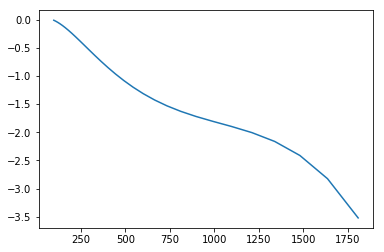

In [14]:
intdhsf=np.zeros((len(ttnpt)-1,3))
it=0.0
iterror=0.0
for i in xrange(len(ttnpt)-1):
    T1=ttnpt[i+1]
    it += 0.5*(dhsf[i]/ttnpt[i]+dhsf[i+1]/ttnpt[i+1])*(ltnpt[i+1]-ltnpt[i])
    iterror += 0.5*((dhsferror[i]/ttnpt[i])**2.+(dhsferror[i+1]/ttnpt[i+1])**2.)*(ltnpt[i+1]-ltnpt[i])
    intdhsf[i,0]=T1
    intdhsf[i,1]=-it*T1
    intdhsf[i,2]=np.sqrt(iterror)*T1
#print intdhsf
plt.plot(intdhsf[:,0],intdhsf[:,1])
plt.show()

## Now we put all the pieces together
## From the paper we have
###     $\dfrac{G(P,T_1)}{k_B T_1} = \dfrac{G(P,0)}{k_B T_1}+ \dfrac{G(P,T_0) - G(P,0)}{k_B T_0} -(3N-3) \ln(\dfrac{T_1}{T_0})- \int_{T_0}^{T_1} \dfrac{\left<\delta H\right>_{P,T}}{k_B T^2} dT.$
### so
### $G(P,T_1) = G(P,0)+ \dfrac{T_1}{T_0}(G(P,T_0) - G(P,0)) -(3N-3)k_B T_1 \ln(\dfrac{T_1}{T_0})-T_1\int_{\ln T_0}^{\ln T_1} \left<\delta H\right>_{P,T}e^{-y} dy$
### Note: These expressions are for systems with contrained center of mass

In [15]:
Gfcc=np.zeros((len(ttnpt)-1,3))
for i in xrange(len(ttnpt)-1):
    T1=intdhfcc[i,0]
    Gfcc[i,0]=T1
    Gfcc[i,1]=intdhfcc[i,1]+U0fcc+(T1/T0)*(GfccT0-U0fcc)-nfreefcc*kbev*T1*np.log(T1/T0)
    Gfcc[i,2]=intdhfcc[i,2]+(T1/T0)*GfccT0error
print Gfcc

[[  9.90000000e+01  -6.10012725e+03   9.74458135e-04]
 [  1.09000000e+02  -6.10031548e+03   1.18590245e-03]
 [  1.21000000e+02  -6.10099286e+03   1.42044051e-03]
 [  1.34000000e+02  -6.10222914e+03   1.66717459e-03]
 [  1.48000000e+02  -6.10408817e+03   1.93039765e-03]
 [  1.63000000e+02  -6.10662969e+03   2.21230131e-03]
 [  1.81000000e+02  -6.11035813e+03   2.55188854e-03]
 [  2.00000000e+02  -6.11501958e+03   2.91269841e-03]
 [  2.21000000e+02  -6.12095472e+03   3.31477061e-03]
 [  2.44000000e+02  -6.12830818e+03   3.75909878e-03]
 [  2.70000000e+02  -6.13759129e+03   4.26614653e-03]
 [  2.98000000e+02  -6.14862967e+03   4.81747573e-03]
 [  3.30000000e+02  -6.16243897e+03   5.45381507e-03]
 [  3.64000000e+02  -6.17837296e+03   6.13666408e-03]
 [  4.03000000e+02  -6.19809562e+03   6.92779705e-03]
 [  4.45000000e+02  -6.22089688e+03   7.78843844e-03]
 [  4.92000000e+02  -6.24814725e+03   8.76108611e-03]
 [  5.44000000e+02  -6.28022662e+03   9.84785095e-03]
 [  6.01000000e+02  -6.31749

[[  9.90000000e+01  -5.59176742e+03   1.03723821e-03]
 [  1.09000000e+02  -5.59193809e+03   1.25121460e-03]
 [  1.21000000e+02  -5.59255675e+03   1.48899636e-03]
 [  1.34000000e+02  -5.59368746e+03   1.73935012e-03]
 [  1.48000000e+02  -5.59538879e+03   2.00645514e-03]
 [  1.63000000e+02  -5.59771546e+03   2.29245740e-03]
 [  1.81000000e+02  -5.60112943e+03   2.63689521e-03]
 [  2.00000000e+02  -5.60539838e+03   3.00269513e-03]
 [  2.21000000e+02  -5.61083437e+03   3.41008267e-03]
 [  2.44000000e+02  -5.61756992e+03   3.85998089e-03]
 [  2.70000000e+02  -5.62607355e+03   4.37308842e-03]
 [  2.98000000e+02  -5.63618567e+03   4.93083339e-03]
 [  3.30000000e+02  -5.64883672e+03   5.57421985e-03]
 [  3.64000000e+02  -5.66343473e+03   6.26426285e-03]
 [  4.03000000e+02  -5.68150434e+03   7.06333167e-03]
 [  4.45000000e+02  -5.70239512e+03   7.93203457e-03]
 [  4.92000000e+02  -5.72736287e+03   8.91328042e-03]
 [  5.44000000e+02  -5.75675577e+03   1.00093409e-02]
 [  6.01000000e+02  -5.79090

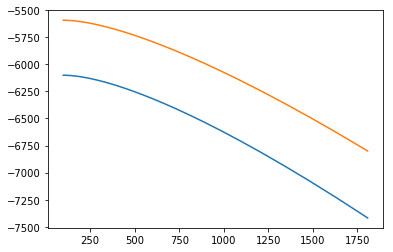

In [16]:
Gsf=np.zeros((len(ttnpt)-1,3))
for i in xrange(len(ttnpt)-1):
    T1=intdhsf[i,0]
    Gsf[i,0]=T1
    Gsf[i,1]=intdhsf[i,1]+U0sf+(T1/T0)*(GsfT0-U0sf)-nfreesf*kbev*T1*np.log(T1/T0)
    Gsf[i,2]=intdhsf[i,2]+(T1/T0)*GsfT0error

print Gsf

plt.plot(Gfcc[:,0],Gfcc[:,1])
plt.plot(Gsf[:,0],Gsf[:,1])
plt.show()

# This the free energy associated with the center of mass
### $\Delta A_{cm}(N, V, T)=-k_B T\left(\ln\dfrac{V}{N \Lambda^3}+\dfrac{3}{2}\ln N\right)$
### $ \Lambda=(2\pi \hbar^2/(atomicmass\times dalton \times k_B  T))^{1/2}=17.458218 /\sqrt{T*atomicmass}~A$
### For FCC Fe At 0K, $V/N=12.459008 A^3$
### Now we add this to the free energy in order to retrieve the free energy of the uncontrained system

In [17]:
massni=55.845
vdivideN=12.459008
for i in xrange(len(Gfcc)):
    T1 = Gfcc[i,0]
    acm = -kbev*T1*(np.log(vdivideN/(17.458218/np.sqrt(T1*massni))**3.)+1.5*np.log(natomfcc))
    #print T1, acm
    Gfcc[i,1] += acm
print Gfcc

[[  9.90000000e+01  -6.10027892e+03   9.74458135e-04]
 [  1.09000000e+02  -6.10048382e+03   1.18590245e-03]
 [  1.21000000e+02  -6.10118137e+03   1.42044051e-03]
 [  1.34000000e+02  -6.10243967e+03   1.66717459e-03]
 [  1.48000000e+02  -6.10432260e+03   1.93039765e-03]
 [  1.63000000e+02  -6.10688991e+03   2.21230131e-03]
 [  1.81000000e+02  -6.11064954e+03   2.55188854e-03]
 [  2.00000000e+02  -6.11534416e+03   2.91269841e-03]
 [  2.21000000e+02  -6.12131624e+03   3.31477061e-03]
 [  2.44000000e+02  -6.12871044e+03   3.75909878e-03]
 [  2.70000000e+02  -6.13803994e+03   4.26614653e-03]
 [  2.98000000e+02  -6.14912865e+03   4.81747573e-03]
 [  3.30000000e+02  -6.16299588e+03   5.45381507e-03]
 [  3.64000000e+02  -6.17899187e+03   6.13666408e-03]
 [  4.03000000e+02  -6.19878614e+03   6.92779705e-03]
 [  4.45000000e+02  -6.22166507e+03   7.78843844e-03]
 [  4.92000000e+02  -6.24900296e+03   8.76108611e-03]
 [  5.44000000e+02  -6.28117984e+03   9.84785095e-03]
 [  6.01000000e+02  -6.31855

In [18]:
for i in xrange(len(Gsf)):
    T1 = Gsf[i,0]
    acm = -kbev*T1*(np.log(vdivideN/(17.458218/np.sqrt(T1*massni))**3.)+1.5*np.log(natomsf))
    #print T1, acm
    Gsf[i,1] += acm
print Gsf

[[  9.90000000e+01  -5.59191797e+03   1.03723821e-03]
 [  1.09000000e+02  -5.59210521e+03   1.25121460e-03]
 [  1.21000000e+02  -5.59274390e+03   1.48899636e-03]
 [  1.34000000e+02  -5.59389648e+03   1.73935012e-03]
 [  1.48000000e+02  -5.59562156e+03   2.00645514e-03]
 [  1.63000000e+02  -5.59797385e+03   2.29245740e-03]
 [  1.81000000e+02  -5.60141880e+03   2.63689521e-03]
 [  2.00000000e+02  -5.60572071e+03   3.00269513e-03]
 [  2.21000000e+02  -5.61119340e+03   3.41008267e-03]
 [  2.44000000e+02  -5.61796943e+03   3.85998089e-03]
 [  2.70000000e+02  -5.62651917e+03   4.37308842e-03]
 [  2.98000000e+02  -5.63668130e+03   4.93083339e-03]
 [  3.30000000e+02  -5.64938993e+03   5.57421985e-03]
 [  3.64000000e+02  -5.66404955e+03   6.26426285e-03]
 [  4.03000000e+02  -5.68219033e+03   7.06333167e-03]
 [  4.45000000e+02  -5.70315830e+03   7.93203457e-03]
 [  4.92000000e+02  -5.72821304e+03   8.91328042e-03]
 [  5.44000000e+02  -5.75770287e+03   1.00093409e-02]
 [  6.01000000e+02  -5.79195

# Now compute stacking fault free energy
### $G_\text{SF} = G_\text{sf} - \dfrac{N_\text{sf}}{N_\text{fcc}} G_\text{fcc}$

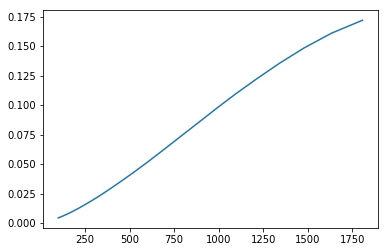

In [19]:
Gv=np.zeros((len(ttnpt)-1,3))
for i in xrange(len(ttnpt)-1):
    T1=Gsf[i,0]
    Gv[i,0]=T1
    Gv[i,1]=Gsf[i,1]-Gfcc[i,1]*natomsf/natomfcc
    Gv[i,2]=np.sqrt(Gsf[i,2]**2.0+Gfcc[i,2]**2.0)
    
plt.plot(Gv[:,0],Gv[:,1])
plt.show()